In [2]:
import sys
import os
import os
import requests
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from Model.GCN_model import GCN, GCN_pyg
from utils import *
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim

# Download the required Dataset

In [3]:
dataset_dir = '../MolDataset'
file_path = os.path.join(dataset_dir, 'HIV.csv')
url = 'https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/HIV.csv'

# Check if the dataset directory exists; if not, create it
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

# Check if the file already exists; if not, download it
if not os.path.exists(file_path):
    print("Downloading HIV.csv...")
    response = requests.get(url, stream=True)
    
    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        with open(file_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    file.write(chunk)
        print("Download complete. File saved to:", file_path)
    else:
        print("Failed to download file. Status code:", response.status_code)
else:
    print("File already exists:", file_path)

File already exists: ../MolDataset/HIV.csv


In [4]:
df = pd.read_csv('../MolDataset/HIV.csv')

In [5]:
df.activity.value_counts()

activity
CI    39684
CM     1039
CA      404
Name: count, dtype: int64

In [6]:
smiles_list = []
atom_types_list = []
adj_matrix_list = []
edge_list_list = []
atomic_num_symbol_map_list = []
hiv_activity_list = []
for idx, row in df.iterrows():
    smiles = row['smiles']
    hiv_activity = row['HIV_active']
    atom_types, adj_matrix, edge_list, atomic_num_symbol_map = process_molecule(smiles)
    # Append the results to the respective lists
    smiles_list.append(smiles)
    atom_types_list.append(atom_types)
    adj_matrix_list.append(adj_matrix)
    edge_list_list.append(edge_list)
    atomic_num_symbol_map_list.append(atomic_num_symbol_map)
    hiv_activity_list.append(hiv_activity)

[09:44:03] WARNING: not removing hydrogen atom without neighbors
[09:44:03] WARNING: not removing hydrogen atom without neighbors


In [7]:
df_processed = pd.DataFrame({
    'smiles': smiles_list,
    'atom_types': atom_types_list,
    'adj_matrix': adj_matrix_list,
    'edge_list': edge_list_list,
    'atomic_num_symbol_map': atomic_num_symbol_map_list,
    'hiv_activity': hiv_activity_list
})

In [9]:
atomic_num_symbol_map

{8: 'O', 7: 'N', 6: 'C', 33: 'As'}

In [11]:
edge_list

[(0, 1),
 (1, 0),
 (1, 2),
 (2, 1),
 (1, 3),
 (3, 1),
 (3, 4),
 (4, 3),
 (4, 5),
 (5, 4),
 (5, 6),
 (6, 5),
 (6, 7),
 (7, 6),
 (7, 8),
 (8, 7),
 (7, 9),
 (9, 7),
 (7, 10),
 (10, 7),
 (6, 11),
 (11, 6),
 (11, 12),
 (12, 11),
 (12, 3),
 (3, 12)]

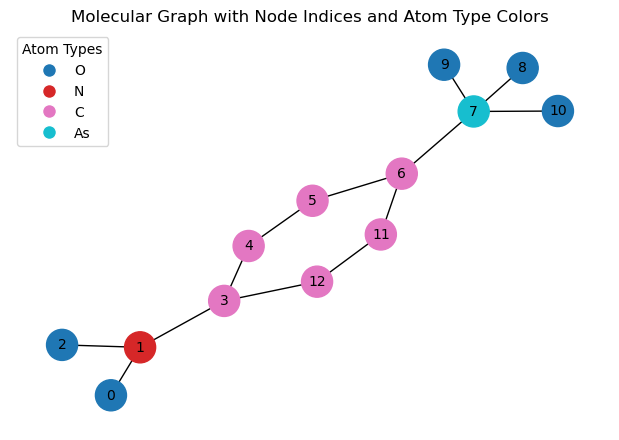

In [8]:
id = 281
edge_list = df_processed['edge_list'][id]
atom_types = df_processed['atom_types'][id]
atomic_num_symbol_map = df_processed['atomic_num_symbol_map'][id]
visualize_molecule_graph(edge_list, atom_types, atomic_num_symbol_map)

In [8]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [9]:
pyg_data_list = [Data(x=torch.tensor(df_processed['atom_types'][i], dtype=torch.float).reshape(-1,1), edge_index=torch.tensor(df_processed['edge_list'][i], dtype=torch.long).t().contiguous(), y=torch.tensor(df_processed['hiv_activity'][i], dtype=torch.long)) for i in range(len(df_processed))]

In [10]:
loader = DataLoader(pyg_data_list, batch_size=32, shuffle=False)

In [11]:
data_batch = next(iter(loader))

In [12]:
data_batch.edge_index

tensor([[  0,   1,   1,  ..., 611, 620, 613],
        [  1,   0,   2,  ..., 614, 613, 620]])

In [13]:
from Model.model_utils import *
processor = GraphProcessor(edge_list=data_batch.edge_index)
processor.add_self_loops()
processor.normalize_adj_matrix()

tensor([[0.5000, 0.5000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000]])

In [14]:
model = GCN(input_dim=1, hidden_dim=64, num_class=2, layers=2)
out = model(data_batch)

In [15]:
class GCNTrainer:
    def __init__(self, model, learning_rate=0.001):
        """
        Initializes the GCNTrainer.
        Parameters:
        - model: The GCN model to be trained.
        - learning_rate: Learning rate for the optimizer.
        """
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)  # Using Adam optimizer
        self.criterion = nn.CrossEntropyLoss()  # Assuming a multi-class classification task

    def train(self, dataloader):
        """
        Trains the model over one epoch.
        Parameters:
        - dataloader: DataLoader for the training data.
        """
        self.model.train()  # Set the model to training mode
        total_loss = 0

        for batch in dataloader:
            # Zero the gradients
            self.optimizer.zero_grad()

            # Forward pass
            output = self.model(batch)

            # Compute loss: the criterion expects output to be [batch_size, num_classes] and y to be [batch_size]
            loss = self.criterion(output, batch.y)

            # Backward pass
            loss.backward()

            # Update weights
            self.optimizer.step()

            total_loss += loss.item()

        return total_loss / len(dataloader)

    def evaluate(self, dataloader):
        """
        Evaluates the model on the validation/test data.
        Parameters:
        - dataloader: DataLoader for the validation or test data.
        Returns:
        - accuracy: The accuracy of the model over the test set.
        - recall: The recall for the positive class (class 1).
        """
        self.model.eval()  # Set the model to evaluation mode
        total_correct = 0
        total_samples = 0

        # Variables for recall calculation
        true_positives = 0  # Correctly predicted positives
        false_negatives = 0  # Actual positives, predicted as negatives
        actual_positives = 0  # Actual number of positive samples

        with torch.no_grad():
            for batch in dataloader:
                output = self.model(batch)  # Forward pass through the model
                pred = output.argmax(dim=1)  # Get predicted class
                
                # Accuracy calculation
                total_correct += (pred == batch.y).sum().item()
                total_samples += batch.y.size(0)

                # Recall calculation
                true_positives += ((pred == 1) & (batch.y == 1)).sum().item()  # True positives
                false_negatives += ((pred == 0) & (batch.y == 1)).sum().item()  # False negatives
                actual_positives += (batch.y == 1).sum().item()  # Total actual positives

        accuracy = total_correct / total_samples if total_samples > 0 else 0

        return accuracy

In [16]:
# train_loader = DataLoader(pyg_data_list[:1000], batch_size=128, shuffle=True)
# model = GCN(input_dim=1, hidden_dim=8, num_class=2, layers=2, pooling="mean")

# # Initialize the trainer
# trainer = GCNTrainer(model=model, learning_rate=0.001)

# # Training loop
# num_epochs = 50
# for epoch in range(num_epochs):
#     train_loss = trainer.train(train_loader)
#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}")

In [18]:
train_loader = DataLoader(pyg_data_list[:1000], batch_size=128, shuffle=True)
pyg_model = GCN_pyg(input_dim=1, hidden_dim=32, num_class=2, layers=2, pooling="max")

In [19]:
trainer = GCNTrainer(model=pyg_model, learning_rate=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    train_loss = trainer.train(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}")

Epoch 1/50, Loss: 0.4574
Epoch 2/50, Loss: 0.2756
Epoch 3/50, Loss: 0.1929
Epoch 4/50, Loss: 0.1591
Epoch 5/50, Loss: 0.1497
Epoch 6/50, Loss: 0.1490
Epoch 7/50, Loss: 0.1490
Epoch 8/50, Loss: 0.1483
Epoch 9/50, Loss: 0.1504
Epoch 10/50, Loss: 0.1499
Epoch 11/50, Loss: 0.1486
Epoch 12/50, Loss: 0.1461
Epoch 13/50, Loss: 0.1488
Epoch 14/50, Loss: 0.1468
Epoch 15/50, Loss: 0.1464
Epoch 16/50, Loss: 0.1469
Epoch 17/50, Loss: 0.1448
Epoch 18/50, Loss: 0.1462
Epoch 19/50, Loss: 0.1453
Epoch 20/50, Loss: 0.1470
Epoch 21/50, Loss: 0.1469
Epoch 22/50, Loss: 0.1443
Epoch 23/50, Loss: 0.1434
Epoch 24/50, Loss: 0.1440
Epoch 25/50, Loss: 0.1428
Epoch 26/50, Loss: 0.1421
Epoch 27/50, Loss: 0.1433
Epoch 28/50, Loss: 0.1411
Epoch 29/50, Loss: 0.1416
Epoch 30/50, Loss: 0.1412
Epoch 31/50, Loss: 0.1399
Epoch 32/50, Loss: 0.1405
Epoch 33/50, Loss: 0.1420
Epoch 34/50, Loss: 0.1403
Epoch 35/50, Loss: 0.1405
Epoch 36/50, Loss: 0.1410
Epoch 37/50, Loss: 0.1387
Epoch 38/50, Loss: 0.1384
Epoch 39/50, Loss: 0.

In [20]:
trainer.evaluate(train_loader)

0.971